# Letalidade - Tempo entre 1o caso e 1a morte na UF
Esse trabalho procura ver a letalidade de uma outra forma.

In [1]:
import pandas as pd
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

In [2]:
path = "\\".join(os.getcwd().split("\\")[:-2])
path

'C:\\Users\\Camila\\Documents\\git\\common_data'

In [3]:
# Importing the Excel file with all the cities
covid_munic = pd.read_csv(path+"\data\caso_full.csv")
covid_munic["date"] = pd.to_datetime(covid_munic['date'], format="%Y/%m/%d")
covid_munic.head(1)

,city,city_ibge_code,date,epidemiological_week,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
0,São Paulo,3550308.0,2020-02-25,9,12252023.0,False,False,1,0.00816,2020-02-25,0.0,0,1,city,SP,1,0


In [4]:
# Understanding the data
covid_munic[covid_munic["city_ibge_code"] == 4307500.0].head()

,city,city_ibge_code,date,epidemiological_week,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
13818,Espumoso,4307500.0,2020-04-13,16,15588.0,False,False,1,6.41519,2020-04-13,0.0,0,1,city,RS,1,0
14940,Espumoso,4307500.0,2020-04-14,16,15588.0,False,False,1,6.41519,2020-04-14,0.0,0,2,city,RS,0,0
16123,Espumoso,4307500.0,2020-04-15,16,15588.0,False,False,1,6.41519,2020-04-15,0.0,0,3,city,RS,0,0
17370,Espumoso,4307500.0,2020-04-16,16,15588.0,False,False,1,6.41519,2020-04-16,0.0,0,4,city,RS,0,0
18683,Espumoso,4307500.0,2020-04-17,16,15588.0,False,False,1,6.41519,2020-04-17,0.0,0,5,city,RS,0,0


In [5]:
# We have the data in 2 ways, by city (not all in there) and state, watch out to not duplicate
# We will use only place_type = "state" for this analysis
# Population only for the cities with Covid
covid_munic.groupby("place_type")[["last_available_confirmed", "last_available_deatsh", "estimated_population_2019"]].sum()

,new_confirmed,new_deaths,estimated_population_2019
place_type,,,
city,374831,23396,1.087107e+10
state,376411,23504,1.661970e+10


In [6]:
print("Last updated in: {:%d/%m/%Y}".format(max(covid_munic["date"])))

Last updated in: 25/05/2020


In [7]:
# We just need it by UF, so let's aggregate them
# Only leaving cases where we have at least one confirmed or one death
# And then create a cumulative frequency for confirmed cases and death 

covid_uf = covid_munic[covid_munic["place_type"] == "state"].groupby(["state", "date"])["new_confirmed", "new_deaths"].sum().reset_index()

covid_uf = covid_uf[(covid_uf["new_confirmed"] > 0) | (covid_uf["new_deaths"] > 0)]

covid_uf["date"] = pd.to_datetime(covid_uf['date'], format="%Y/%m/%d")

# Adding cumulative
covid_uf['Cumulative Confirmed'] = covid_uf.groupby('state')['new_confirmed'].cumsum()
covid_uf['Cumulative Death'] = covid_uf.groupby('state')['new_deaths'].cumsum()
covid_uf.tail(2)

C:\Users\Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


,state,date,new_confirmed,new_deaths,Cumulative Confirmed,Cumulative Death
1998,TO,2020-05-22,225,2,2430,51
2001,TO,2020-05-25,266,7,2696,58


In [8]:
print("First date: {:%d/%m/%Y}".format(min(covid_uf["date"])))
print("Last updated in: {:%d/%m/%Y}".format(max(covid_uf["date"])))
covid_uf[["new_confirmed", "new_deaths"]].sum()

First date: 25/02/2020
Last updated in: 25/05/2020


new_confirmed    376411
new_deaths        23504
dtype: int64

In [9]:
covid_uf.groupby("date")["state"].count().tail(10)

date
2020-05-16    26
2020-05-17    27
2020-05-18    27
2020-05-19    26
2020-05-20    26
2020-05-21    25
2020-05-22    27
2020-05-23    24
2020-05-24    25
2020-05-25    19
Name: state, dtype: int64

In [10]:
# Because we only have 19 states on our last date, we will delete it
# Not all states update every day, so 25 should be fine
covid_uf = covid_uf[ covid_uf["date"] < max(covid_uf["date"])]
# covid_uf = covid_uf[ covid_uf["date"] < max(pd.to_datetime(['2020-05-23'], format="%Y/%m/%d"))]

print("We have {} states with last updated in: {:%d/%m/%Y}".
      format(covid_uf[covid_uf["date"] == max(covid_uf["date"])] ["state"].count(), 
             max(covid_uf["date"])))

We have 25 states with last updated in: 24/05/2020


In [11]:
# Getting first cases in Brazil for confirmed and death
last_updated = max(covid_uf["date"])
first_br_confirmed = covid_uf[covid_uf["new_confirmed"] > 0]["date"].min()
first_br_death = covid_uf[covid_uf["new_deaths"] > 0]["date"].min()
print("First confirmed and death in Brasil: {:%d/%m/%Y} and {:%d/%m/%Y}".format(first_br_confirmed, first_br_death))

First confirmed and death in Brasil: 25/02/2020 and 17/03/2020


In [12]:
# Now let's get a summary for the UF
covid_uf_summary = covid_uf.groupby("state")["new_confirmed", "new_deaths"].sum()

#Creating a label for the graph with # cases
covid_uf_summary["Estado"] = [' - '.join(i) for i in 
                              zip(covid_uf_summary.index.values, covid_uf_summary["new_confirmed"].map(str) )]

# Create Region
region = {'AC': "Norte", 'AM': "Norte", 'AP': "Norte", 'PA': "Norte", 'RO': "Norte", 'RR': "Norte", 'TO': "Norte",
          'AL': "Nordeste", 'BA': "Nordeste", 'CE': "Nordeste", 'MA': "Nordeste", 'PB': "Nordeste", 'PE': "Nordeste", 
          'PI': "Nordeste", 'RN': "Nordeste", 'SE': "Nordeste", 
          'DF': "Centro Oeste", 'GO': "Centro Oeste", 'MS': "Centro Oeste", 'MT': "Centro Oeste",
          'ES': "Sudeste", 'MG': "Sudeste", 'RJ': "Sudeste", 'SP': "Sudeste",
          'PR': "Sul", 'SC': "Sul", 'RS': "Sul"}

covid_uf_summary['Region'] = covid_uf_summary.index.to_series().map(region)
# .apply(lambda x: region[x["state"]], axis=1)

covid_uf_summary['Death Rate'] = covid_uf_summary["new_deaths"] / covid_uf_summary["new_confirmed"] * 100

covid_uf_summary.tail(2)

C:\Users\Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,new_confirmed,new_deaths,Estado,Region,Death Rate
state,,,,,
SP,82161,6163,SP - 82161,Sudeste,7.501126
TO,2430,51,TO - 2430,Norte,2.098765


In [13]:
covid_uf_summary.sum()

new_confirmed                                               365674
new_deaths                                                   22850
Estado           AC - 4160AL - 6214AM - 29867AP - 6353BA - 1389...
Region           NorteNordesteNorteNorteNordesteNordesteCentro ...
Death Rate                                                 112.994
dtype: object

In [14]:
# Now we create the Dates and days since that we want
covid_uf_summary["Date Case 1 in UF"] = covid_uf[covid_uf["new_confirmed"] > 0].groupby("state")["date"].min()
covid_uf_summary["Date first death in UF"] = covid_uf[covid_uf["new_deaths"] > 0].groupby("state")["date"].min()
covid_uf_summary["Dias entre Caso 1 brasileiro e Caso 1 na UF"] = (covid_uf_summary["Date Case 1 in UF"] - first_br_confirmed).dt.days
covid_uf_summary["Dias entre Caso 1 brasileiro e morte na UF"] = (covid_uf_summary["Date first death in UF"] - first_br_confirmed).dt.days
covid_uf_summary["Dias entre Caso 1 e morte na UF"] = (covid_uf_summary["Date first death in UF"] - covid_uf_summary["Date Case 1 in UF"]).dt.days
    
covid_uf_summary.tail(2)

,new_confirmed,new_deaths,Estado,Region,Death Rate,Date Case 1 in UF,Date first death in UF,Dias entre Caso 1 brasileiro e Caso 1 na UF,Dias entre Caso 1 brasileiro e morte na UF,Dias entre Caso 1 e morte na UF
state,,,,,,,,,,
SP,82161,6163,SP - 82161,Sudeste,7.501126,2020-02-25,2020-03-17,0,21,21
TO,2430,51,TO - 2430,Norte,2.098765,2020-03-18,2020-04-15,22,50,28


In [15]:
# Function to add the label
def labeling(ax, has_digits):
    
    for rect in ax.patches:
        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        # The width of the bar is the data value and can used as the label
        if has_digits != 0:
            label_text = f'{width/100:.1%}'
        else:
            label_text = f'{width:.0f}'  # f'{height:.2f}' to format decimal values
        
        if np.isnan(x) == False and np.isnan(y) == False and width > 0:
            label_x = x + width - 0.2  # adjust 0.2 to center the label
            label_y = y + height / 2
            ax.text(label_x, label_y, label_text, ha='right', va='center', fontsize=9, color='white', fontname='MS Gothic')

# Formatting the graph
def graph_features(ax, fig, has_digits=0):
    # Put the value labels
    labeling(ax, has_digits)
    
#     # Adding legend on the bottom
#     handles, labels = plt.gca().get_legend_handles_labels()
#     order = list(range(1, len(columns_for_graph) + 1))
#     order.extend([0])
    
#     leg = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order]
#                , bbox_to_anchor=(0.45, -0.15), ncol=3, loc='lower center'
#                , facecolor = 'white', frameon=False)    
#     for text in leg.get_texts():
#         plt.setp(text, color = 'w')
    ax.get_legend().remove()
    
    # Taking out boarders and grid - Changing color of grid and background
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(color='#A9A9A9', axis = 'x', linewidth=0.5)
    ax.set_facecolor('#696969') # #696969
    fig.set_facecolor("black")
    ax.tick_params(axis='x', colors="white")
    ax.tick_params(axis='y', colors="white")

    # Getting titles right
    plt.suptitle('Dias até a primeira morte na UF'
                 , fontsize=16, fontname='MS Gothic', color = 'white')
    plt.title('Atualizado em {:%d/%m/%Y}'.format(last_updated)
              , fontsize=10, fontname='MS Gothic', color = 'white')
    plt.ylabel('Estado', fontname='MS Gothic')
    plt.xlabel('Dias', fontname='MS Gothic')

    # Add logo
    
    im = matplotlib.image.imread(path+'\logo\marca BRANCA_vertical.png')
    newax = fig.add_axes([0.81, 0.8, 0.2, 0.2], anchor='NE', frameon = False)
    newax.imshow(im)
    newax.axis('off')
# # The one below puts inside the axis
#     logo_position = ax.get_xlim()[1] * 0.91
#     imagebox = matplotlib.offsetbox.OffsetImage(im, zoom=0.0175)
#     ab = matplotlib.offsetbox.AnnotationBbox(imagebox, (logo_position, -0.2), frameon = False)
#     ax.add_artist(ab)
    
    # Final touch
    fig.tight_layout()
    fig.subplots_adjust(top=0.91)

C:\Users\Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


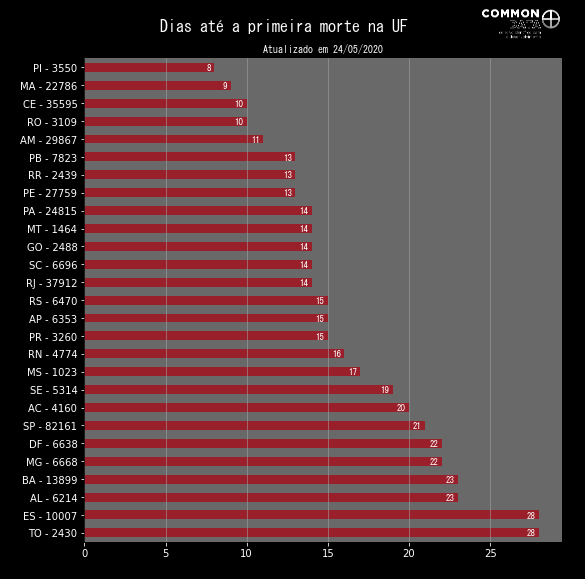

In [16]:
colors = ["#A09F9E", "#6B8E23", "#8da341", "#c7b65f", "#FFD453", "#F7A400", "#CA5C4A", "#991f2a"]

covid_uf_summary.sort_values(by="Dias entre Caso 1 e morte na UF", ascending = False, inplace=True)

fig, ax = plt.subplots(figsize=(8,8))

rects = covid_uf_summary.plot.barh(x="Estado",y="Dias entre Caso 1 e morte na UF", ax=ax, color = colors[::-1][0] )

graph_features(ax, fig)

plt.savefig('Letalidade_dias_ate_1amorte_por_uf.png', facecolor="black")

C:\Users\Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


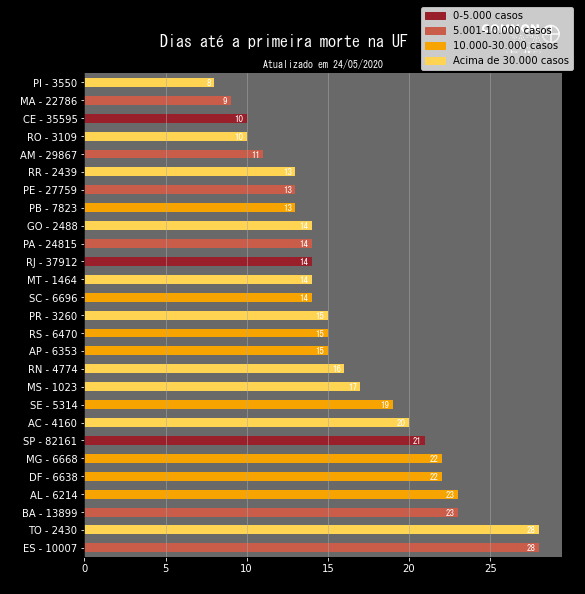

In [20]:
colors = ["#A09F9E", "#6B8E23", "#8da341", "#c7b65f", "#FFD453", "#F7A400", "#CA5C4A", "#991f2a"]
my_cmap = colors[::-1][:4]
my_cmap_rgba = list(map(lambda c: matplotlib.colors.to_rgba(c), my_cmap))

covid_uf_summary.sort_values(by="Dias entre Caso 1 e morte na UF", ascending = False, inplace=True)

color_cases = covid_uf_summary.reset_index()["new_confirmed"].tolist()
for row, cases in enumerate(color_cases):
    if cases >= 30000:
        color_cases[row] = my_cmap[0]
    elif cases >= 10000:
        color_cases[row] = my_cmap[1]
    elif cases >= 5000:
        color_cases[row] = my_cmap[2]
    else: color_cases[row] = my_cmap[3]


        
fig, ax = plt.subplots(figsize=(8,8))

rects = covid_uf_summary.plot.barh(x="Estado",y="Dias entre Caso 1 e morte na UF", ax=ax, color = color_cases)

graph_features(ax, fig)


label=["0-5.000 casos", "5.001-10.000 casos", "10.000-30.000 casos", "Acima de 30.000 casos"]
patch0 = matplotlib.patches.Patch(color=my_cmap_rgba[0], label=label[0])
patch1 = matplotlib.patches.Patch(color=my_cmap_rgba[1], label=label[1])
patch2 = matplotlib.patches.Patch(color=my_cmap_rgba[2], label=label[2])
patch3 = matplotlib.patches.Patch(color=my_cmap_rgba[3], label=label[3])
plt.legend(handles=[patch0, patch1, patch2, patch3], loc='center right')  


plt.savefig('Letalidade_dias_ate_1amorte_por_uf_colorido.png', facecolor="black")

C:\Users\Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


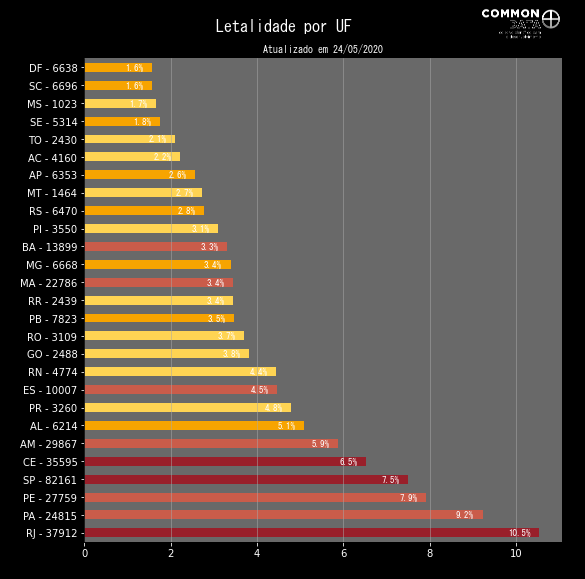

In [18]:
from matplotlib.colors import Normalize
colors = ["#A09F9E", "#6B8E23", "#8da341", "#c7b65f", "#FFD453", "#F7A400", "#CA5C4A", "#991f2a"]
my_cmap = colors[::-1][:4]

covid_uf_summary.sort_values(by="Death Rate", ascending = False, inplace=True)

color_cases = covid_uf_summary.reset_index()["new_confirmed"].tolist()
for row, cases in enumerate(color_cases):
    if cases > 30000:
        color_cases[row] = my_cmap[0]
    elif cases > 10000:
        color_cases[row] = my_cmap[1]
    elif cases > 5000:
        color_cases[row] = my_cmap[2]
    else: color_cases[row] = my_cmap[3]

fig, ax = plt.subplots(figsize=(8,8))

rects = covid_uf_summary.plot.barh(x="Estado",y="Death Rate", ax=ax, color = color_cases)

graph_features(ax, fig, 1)

plt.suptitle('Letalidade por UF'
                 , fontsize=16, fontname='MS Gothic', color = 'white')


plt.savefig('Letalidade_porcentagem_por_uf.png', facecolor="black")